In [1]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
  !wget -O basic_material.py https://www.dropbox.com/s/3aoexl8vxyitmds/basic_material.py?dl=0
%run basic_material

try:
    import google.colab
    IN_COLAB = True
    # don't need serial here
except:
    IN_COLAB = False
    try: 
        import serial
    except:
        !pip3 install pyserial
        import serial

import time, csv, os, requests
 
from os import path
if os.path.isdir("./data/"):
    pass
else:
    !mkdir ./data
    
if os.path.isdir("./figs/"):
    pass
else:
    !mkdir ./figs
    
import random, sys, copy
from numpy.random import randn
import pandas as pd 

plt.rcParams['axes.grid'] = True
plt.style.use('fivethirtyeight') # For better style
plt.rcParams["figure.figsize"] = (8,5)

d2r = np.pi/180
Low_Noise = False

Running Python: 3.8.16


In [2]:
# Now look for the optimal solution
# form cost on 10-2 and optimize it
def func_NLS(xh, Q0, x0, z, L, V):
    xt = xh.reshape(2, 1) - x0
    J1 = xt.T@np.linalg.inv(Q0)@xt
    if (np.size(z) < 2):
        zt = z - np.matrix([Measurement(xh.reshape(2, 1),L)])
    else:
        zt = z - np.matrix([Measurement(xh.reshape(2, 1),L[0]), Measurement(xh.reshape(2, 1),L[1])]).T
    J2 = np.dot(zt.T,zt)/V
    return J1.item() + J2.item()

In [3]:
#actual (unknown) solution
x = np.array([[-3], [0]])

# initial uncertainty in location
Q0 = np.matrix([[0.2**2, 0], [0, 0.3**2]]) # initial state uncertainty

# initially start at xb within +/-1sigma of the actual 
xb = x + sqrtm(Q0)@np.vstack(randn(2)) # initial state used in the opt
xb = np.vstack(np.array([[-3.3], [0.2]])) # interesting problem to solve

if 0:
    L = 4 # +ve taken to be in the negative x_2 direction
    L2 = -2 # location of second measurement
else: # reverse order of meas
    L = -2 
    L2 = 4 
    
TOL = 1e-11 # solution tolerance
rr_max = 12 # max number of iterations

V = (0.7*d2r)**2 # measurement noise
   
# define geometry of problem and 
# measurements, which are the angles between the 2 beacons 
x1,x2,sL = sym.symbols('x1 x2 sL')
r1sq = x1**2 + x2**2
r2sq = x1**2+(x2+sL)**2
fun = sym.acos((sL**2-r1sq-r2sq)/(-2*sym.sqrt(r1sq*r2sq)))
numfun=sym.lambdify([x1,x2,sL],fun) # measurement equation
gradfun=[sym.diff(fun,var) for var in (x1,x2)] #take the gradient symbolically wrt x
numgradfun=sym.lambdify([x1,x2,sL],gradfun) #turn into a bivariate lambda for numpy

def Measurement(xm,L):
    return numfun(xm[0,0],xm[1,0],L)

# Actual measurements
z_act_1 = Measurement(x,L) # beacons 0 and 1
z_act_2 = Measurement(x,L2) # beacons 0 and 2

# add random noise scaled by V
z =  z_act_1 + np.sqrt(V)*randn(1) # measured angle (note the sqrt here)
z3 = z_act_2 + np.sqrt(V)*randn(1) # second measured angle (note the sqrt here)

print(f'Actual state x: ',x.T[0])
print(f'Initial belief: ',xb.T[0])
print('\nActual First Alpha: ' + str(round(z_act_1/d2r,2)),'degs')
print('Meas First Alpha: ' + str(round(z[0]/d2r,2)), 'degs')
print('\nActual Second Alpha: ' + str(round(z_act_2/d2r,2)),'degs')
print('Meas Second Alpha: ' + str(round(z3[0]/d2r,2)), 'degs')

Actual state x:  [-3  0]
Initial belief:  [-3.3000  0.2000]

Actual First Alpha: 33.69 degs
Meas First Alpha: 33.57 degs

Actual Second Alpha: 53.13 degs
Meas Second Alpha: 53.13 degs


In [4]:
# optimized results
# callback storage
all_x_i=[]
all_y_i=[]
all_x_i.append(xb[0][0])
all_y_i.append(xb[1][0])
def store(x):
    all_x_i.append(x[0])
    all_y_i.append(x[1])

In [5]:
def nllsfit(x0,Q0,xk,Qk,z,R,L):  # see 12-4 for equations
    zk = Measurement(xk,L) # measurement would get at current estimate xk 
    H = np.asmatrix(numgradfun(xk[0,0],xk[1,0],L)) # linearized meas matrix
    Qkp1 = np.linalg.inv(np.linalg.inv(Q0) + H.T@np.linalg.inv(np.atleast_2d(R))@H) 
    xkp1 = x0 + Qkp1@H.T*(z - zk - H@(x0 - xk))/R
    zkp1 = Measurement(xkp1,L) # measurement would get at current estimate xk 
    GR = np.linalg.inv(Q0)@(xkp1 - x0) - H.T*(z - zkp1)/R
    return  xkp1, Qkp1, GR

def iterated_solution(x0,Q0,z,V,L):
    # iterated solution
    xh = copy.deepcopy(x0) # temporary solution
    Qh = copy.deepcopy(Q0) # temporary solution
    GR = 1 
    iter_count = 0 #limit on the # of iterations
    X = np.zeros((rr_max+1,3))   # storage
    while ((np.linalg.norm(GR) > TOL) & (iter_count < rr_max)):
        X[iter_count][0:2] = xh.T  
        X[iter_count][2] = iter_count
        xh,Qh,GR = nllsfit(x0,Q0,xh,Qh,z,V,L)
        iter_count += 1
    else:
        X[iter_count][0:2] = x.T  # put actual answer as last value for plotting reasons
        X[iter_count][2] = iter_count
    return np.asarray(xh).flatten(), np.asarray(Qh),  iter_count, X[0:iter_count,:]

In [10]:
def solve_both(xb,Q0,z,V,L):
    xh, Qh, iter_number, X = iterated_solution(xb,Q0,z,V,L)

    kk = minimize(func_NLS, xb[:,0].T, args=(Q0, xb, z, L, V), callback=store)
    BFGS_sol_path = np.array([all_x_i,all_y_i])

    print("Initial", xb.flatten())

    print("Optimized")
    table_opt = []
    table_opt.append(all_x_i)
    table_opt.append(all_y_i)
    df_opt = pd.DataFrame(table_opt, index=['X1', 'X2'])
    df_opt[df_opt.isna()]=0
    print(df_opt.T)

    print("\nIterated")
    table_iterated = []
    table_iterated.append(X[:,0])
    table_iterated.append(X[:,1])
    df_iterated = pd.DataFrame(table_iterated, index=['X1', 'X2'])
    df_iterated[df_iterated.isna()]=0
    print(df_iterated.T)


    fig, ax = plt.subplots()
    ax.plot(all_x_i, all_y_i,'r',label="Optimal")
    ax.plot(X[:,0], X[:,1],'b',label="Iterated")
    ax.plot(all_x_i, all_y_i,'ro')
    ax.plot(X[0,0], X[0,1],'ks')
    ax.plot(X[:,0], X[:,1],'bo')
    ax.plot(x[0], x[1],'gs')
    ax.set_title('Single Optimization Step')
    plt.legend()
    plt.savefig('figs/filename.png',dpi=600, format="png",transparent=True)
    plt.show()

Initial [-3.3000  0.2000]
Optimized
          X1        X2
0  -3.300000  0.200000
1  -3.183223  0.254807
2  -3.199563  0.292772
3  -3.190315  0.299913
4  -3.190897  0.301978
5  -3.190966  0.302156
6  -3.190966  0.302156
7  -3.126909 -0.050078
8  -3.149991 -0.067123
9  -3.152832 -0.084755
10 -3.164123 -0.118839
11 -3.170509 -0.124981
12 -3.171473 -0.125938
13 -3.171477 -0.125945
14 -3.183223  0.254807
15 -3.199563  0.292772
16 -3.190315  0.299913
17 -3.190897  0.301978
18 -3.190966  0.302156
19 -3.190966  0.302156

Iterated
         X1        X2
0 -3.300000  0.200000
1 -3.192964  0.313030
2 -3.190482  0.300812
3 -3.191030  0.302324
4 -3.190958  0.302135
5 -3.190967  0.302159
6 -3.190965  0.302156


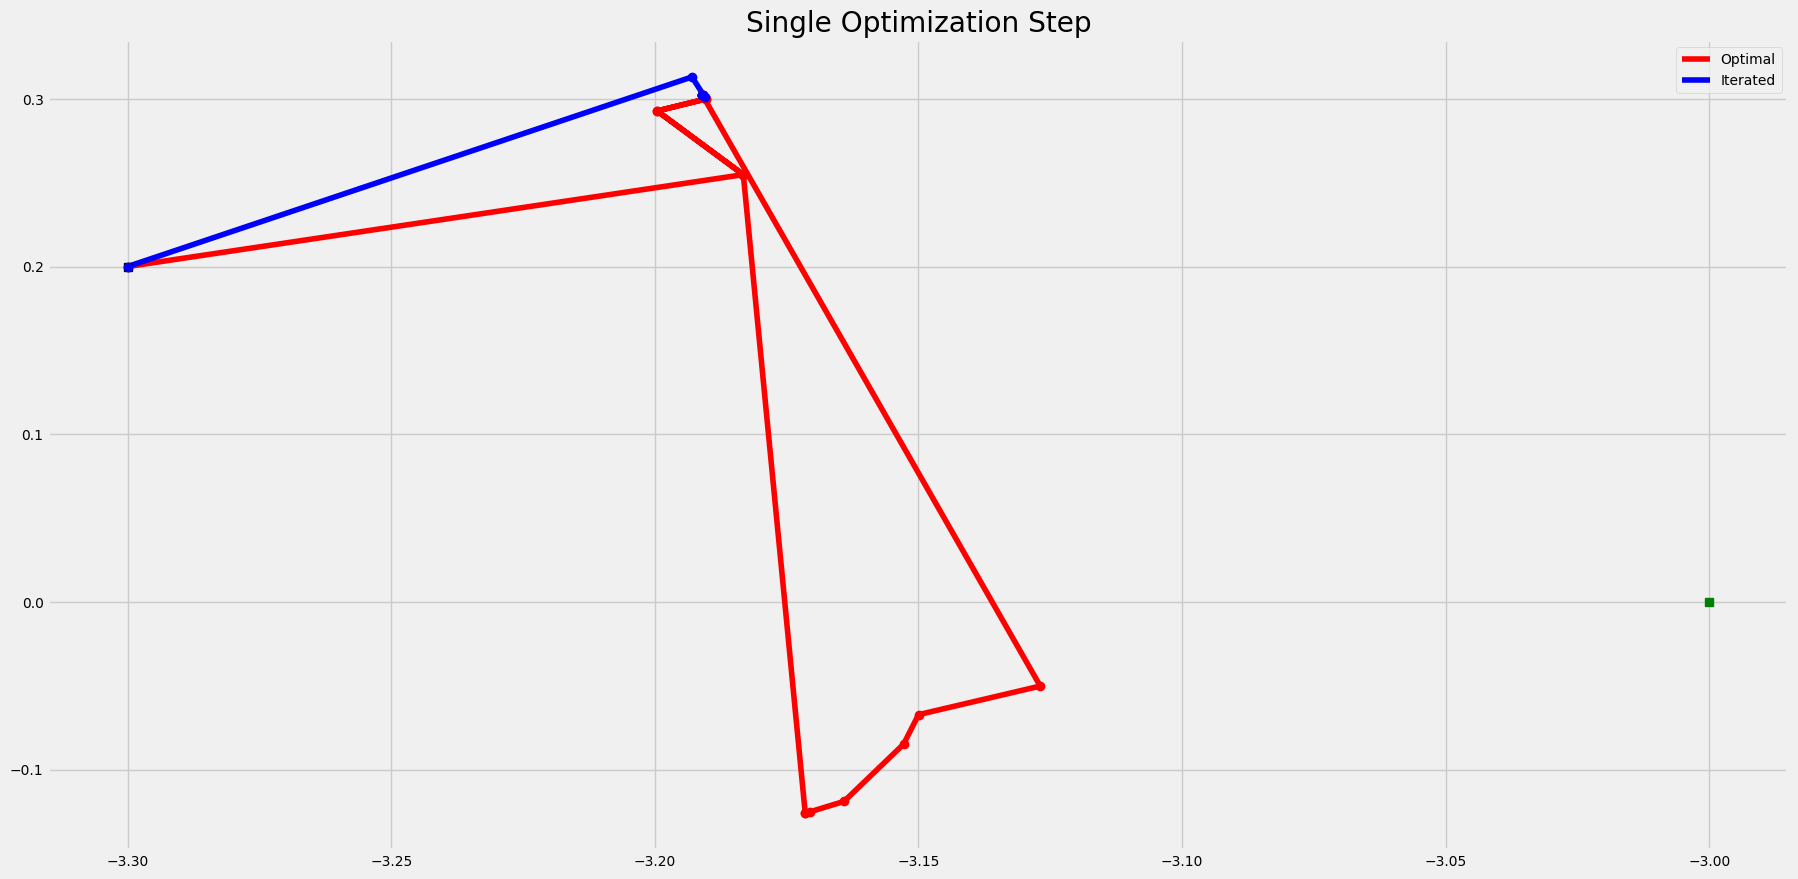

In [11]:
solve_both(xb,Q0,z,V,L)

Initial [-3.3000  0.2000]
Optimized
          X1        X2
0  -3.300000  0.200000
1  -3.183223  0.254807
2  -3.199563  0.292772
3  -3.190315  0.299913
4  -3.190897  0.301978
5  -3.190966  0.302156
6  -3.190966  0.302156
7  -3.126909 -0.050078
8  -3.149991 -0.067123
9  -3.152832 -0.084755
10 -3.164123 -0.118839
11 -3.170509 -0.124981
12 -3.171473 -0.125938
13 -3.171477 -0.125945

Iterated
         X1        X2
0 -3.300000  0.200000
1 -3.191192 -0.153708
2 -3.168754 -0.122951
3 -3.171800 -0.126246
4 -3.171443 -0.125912
5 -3.171480 -0.125948
6 -3.171476 -0.125944
7 -3.171477 -0.125945


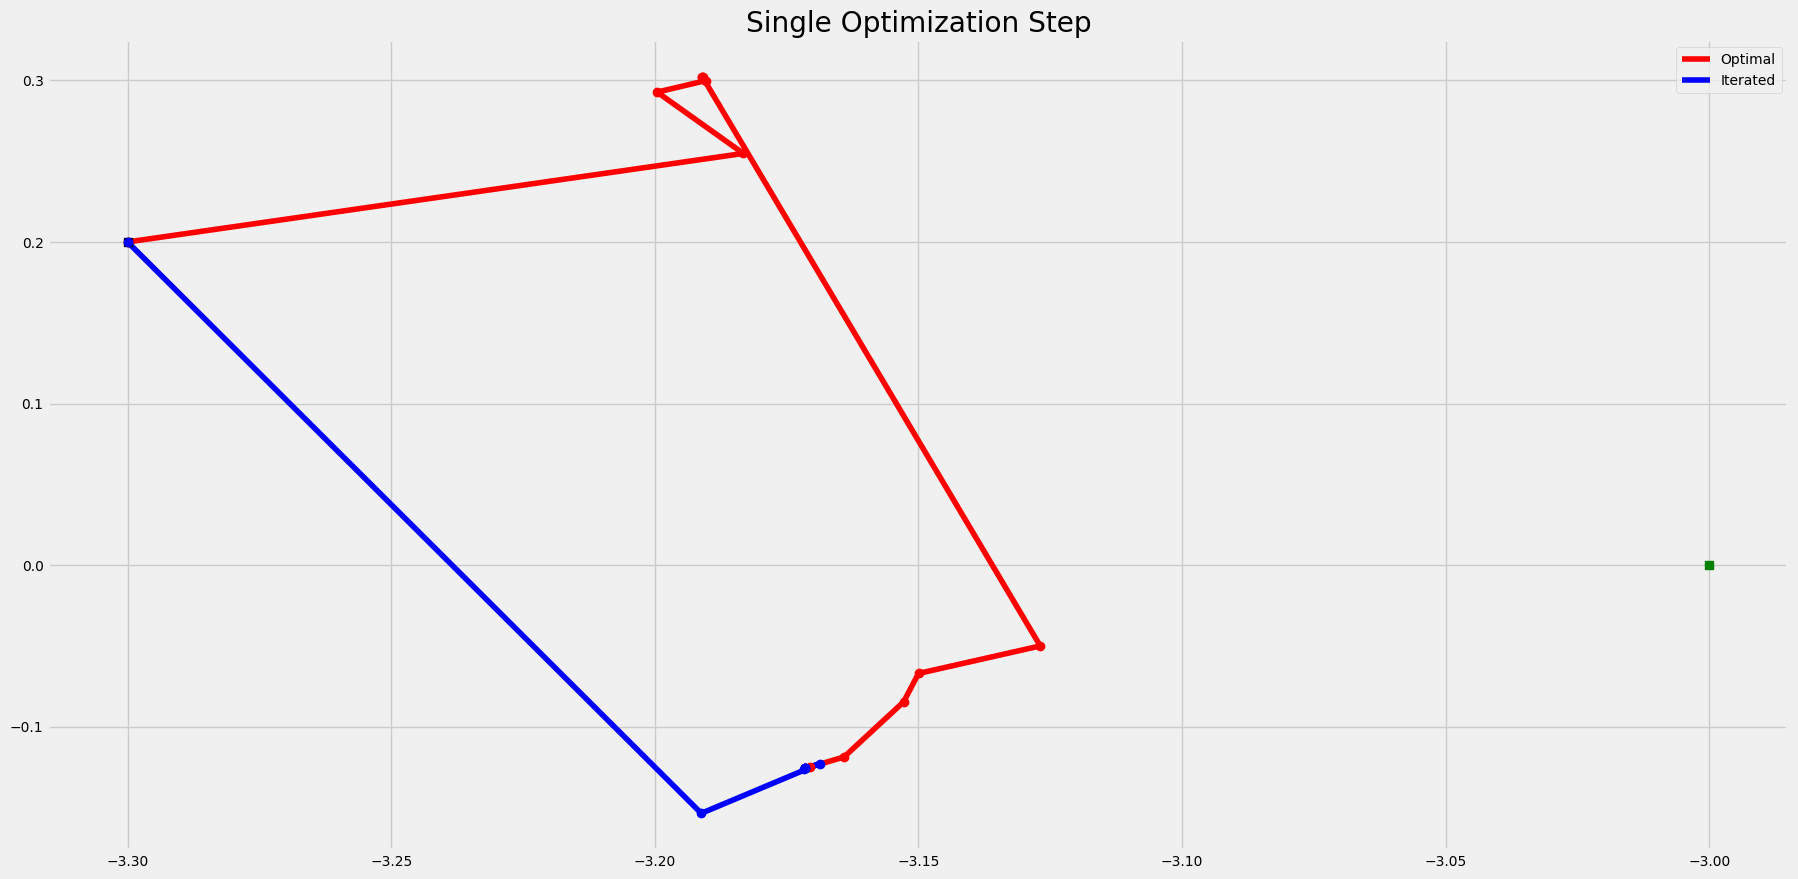

In [8]:
solve_both(xb,Q0,z3,V,L2)